In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

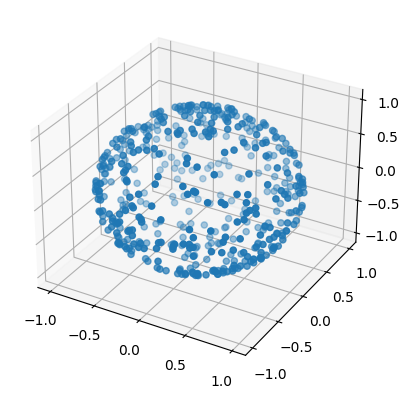

In [2]:
# Source How to generate equidistributed points on the surface of a sphere -- https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf
# Randomly generate 100 points on a sphere
# Radius = 1
# Center = (0,0,0)

n = 500
# Generating z coordinates with radius = 1
z = np.random.uniform(-1,1,n)

# Generating azimuthal angles
phi = np.random.uniform(0,2*math.pi,n)

# Generating x and y coordinates
x = np.sqrt(1-z**2)*np.cos(phi)
y = np.sqrt(1-z**2)*np.sin(phi)

# Plotting the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)
plt.show()

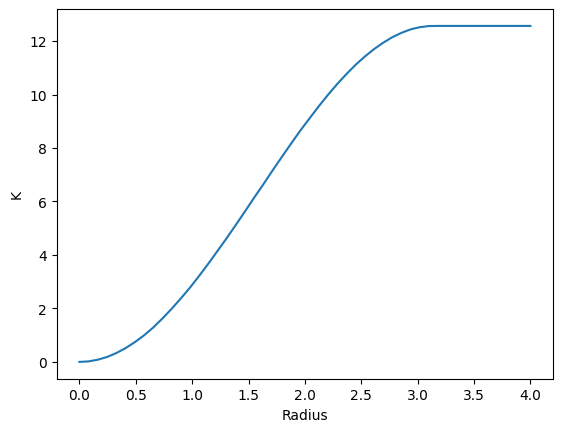

In [3]:
# distance between two points on a sphere 
# https://www.cuemath.com/trigonometry/trigonometric-table/
# Source: https://www.math.ksu.edu/~dbski/writings/haversine.pdf
data = np.array([x,y,z]).T

def distance(r,vec1,vec2):
    # pythagorean theorem
    # d = math.sqrt((vec2[0]-vec1[0])**2 + (vec2[1]-vec1[1])**2 + (vec2[2]-vec1[2])**2)
    d = np.linalg.norm(vec1-vec2)
    # Arc Distance
    dist = r * 2* math.asin(d/2)
    return dist

def pairDistances(r, data):
    npts = np.shape(data)[0]
    dist = []
    for i in range(npts):
        for j in range(i+1, npts):
            #dist.append(distance(r, data[i, 0], data[i, 1], data[i, 2], data[j, 0], data[j, 1], data[j, 2]))
            dist.append(distance(r, data[i], data[j]))
    return dist

# Calculating the distance between all pairs of points
def surfaceArea(r):
    area = 4 * math.pi * r**2
    return area


def ripleyK(r, data, radii):
    K = np.zeros_like(radii)
    area = surfaceArea(r)
    dist = pairDistances(r, data)
    pair_num = len(dist)
    intensity = pair_num / area
    for i in range(len(radii)):
        K[i] = np.sum(dist < radii[i])
    K = K / intensity
    return K

radii = np.linspace(0, 4, 50)

kt = ripleyK(1, data, radii)

# Plotting the Ripley's K function
plt.plot(radii, kt)
plt.xlabel('Radius')
plt.ylabel('K')
plt.show()

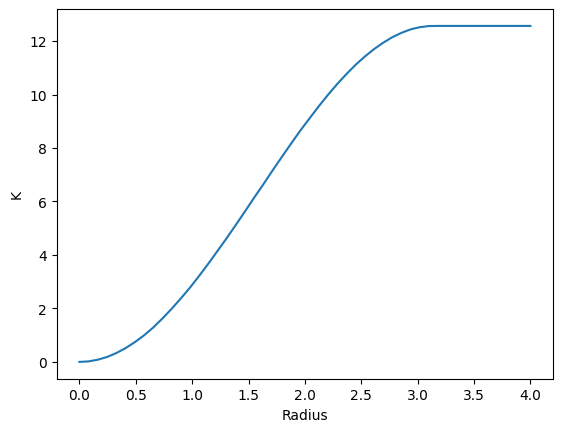

In [4]:
# distance between two points on a sphere 
# https://www.cuemath.com/trigonometry/trigonometric-table/
# Source: https://www.math.ksu.edu/~dbski/writings/haversine.pdf
data = np.array([x,y,z]).T

def distance(radii,vec1,vec2):
    # pythagorean theorem
    # d = math.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
    # Arc Distance
    # dist = r * math.asin(d/2*r*math.sqrt(4*r**2-d**2))
    dist = radii * abs(math.acos(np.dot(vec1, vec2)/radii**2))
    return dist

def pairDistances(r, data):
    npts = np.shape(data)[0]
    dist = []
    for i in range(npts):
        for j in range(i+1, npts):
            #dist.append(distance(r, data[i, 0], data[i, 1], data[i, 2], data[j, 0], data[j, 1], data[j, 2]))
            dist.append(distance(r, data[i], data[j]))
    return dist

# Calculating the distance between all pairs of points
def surfaceArea(r):
    area = 4 * math.pi * r**2
    return area


def ripleyK(r, data, radii):
    K = np.zeros_like(radii)
    area = surfaceArea(r)
    dist = pairDistances(r, data)
    pair_num = len(dist)
    intensity = pair_num / area
    for i in range(len(radii)):
        K[i] = np.sum(dist < radii[i])
    K = K / intensity
    return K

radii = np.linspace(0, 4, 50)

kt = ripleyK(1, data, radii)

# Plotting the Ripley's K function
plt.plot(radii, kt)
plt.xlabel('Radius')
plt.ylabel('K')
plt.show()